In [1]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

from orthnet import Legendre, Chebyshev

%matplotlib inline

2022-05-06 16:13:17.460390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 16:13:17.460415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
class LegendreActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 , i):
            if (i + j) % 2 == 1:
              self.D[i, j] = 2 * (j + 1) - 1
    
    def forward(self, X):              
      data = Legendre(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T


class LegendreBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Legendre = LegendreActivation(self.degree)

    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Legendre(X)
      return data

class ChebyshevActivation(nn.Module):
    def __init__(self,degree):
        super().__init__()
        self.degree = degree
        self.data = None
        
        self.D = torch.zeros((degree , degree )) 
        for i in range(degree):
          for j in range(0 ,i):
            if (i+j) % 2 == 1:
              self.D[i, j] = 2 * i
              if j == 0:
                self.D[i, j] = self.D[i, j]/2.0
    def forward(self, X):              
      data = Chebyshev(X, self.degree).tensor
      self.data = data
      return data

    def backward(self,):
      return (self.D @ (self.data).T).T

class ChebyshevBlock(nn.Module):
    def __init__(self, n_input, degree):        
        super().__init__()
        self.degree = degree - 1
        
        self.n_input = n_input
        self.linear = nn.Linear(self.n_input, 1).double()
        self.tanh = nn.Tanh().double()
        self.Chebyshev = ChebyshevActivation(self.degree)


    def forward(self, X):      
      X = self.tanh(self.linear(X))      
      data = self.Chebyshev(X)
      
      return data

In [4]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)

In [5]:
domain = [0, 1]
n_discretization = 300 * domain[1] - domain[0]

In [6]:
n_input = 1
n_output = 1
eps = 1e-10

In [7]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization, dtype=torch.double).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [8]:
mlp = nn.Sequential(  
  LegendreBlock(n_input, 32),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()


pytorch_total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
pytorch_total_params

19747

In [9]:
def get_loss(x, ret_res=False):
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0, f'(∞) = 1
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  # boundaries same for all equations
  boundary1 = y[0]
  boundary2 = y_x[0]
  boundary3 = y_x[-1] - 1

  loss = (residual**2).mean() + boundary1**2 + boundary2**2 + boundary3**2
  return (loss, residual) if ret_res else loss

In [10]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [11]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 2000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00180.0379095746
Step: 002 loss = 00586.8096136031
Step: 004 loss = 00334.6671415241
Step: 006 loss = 00401.6336906862
Step: 008 loss = 00362.2230419941
Step: 010 loss = 00161.9234985886
Step: 012 loss = 00240.0251285601
Step: 014 loss = 00088.2184942779
Step: 016 loss = 00027.9505791457
Step: 018 loss = 00049.1578933826
Step: 020 loss = 00028.7592823269
Step: 022 loss = 00010.4516637027
Step: 024 loss = 00018.4362475583
Step: 026 loss = 00024.1929561067
Step: 028 loss = 00012.7569366045
Step: 030 loss = 00004.0625146629
Step: 032 loss = 00005.2438046331
Step: 034 loss = 00007.9016627215
Step: 036 loss = 00006.4649491645
Step: 038 loss = 00003.1040352577
Step: 040 loss = 00001.4823550185
Step: 042 loss = 00002.1519775448
Step: 044 loss = 00003.3058778977
Step: 046 loss = 00003.3502295687
Step: 048 loss = 00002.3937158060
Step: 050 loss = 00001.4946384588
Step: 052 loss = 00001.2522692671
Step: 054 loss = 00001.4770833042
Step: 056 loss = 00001.6963480856
Step: 058 loss

In [12]:
pd.options.display.float_format = '{:.16f}'.format
domain_test = torch.tensor([0.00,0.10,0.20,0.50,1.00,1.50,2.00], dtype=torch.double).reshape(-1,1)
predict_test = mlp.forward(domain_test).detach().numpy().flatten()
pd.DataFrame(np.array([domain_test.numpy().flatten(), predict_test]).T, columns=['x','y'])

,x,y
0,0.0000000000000000,0.0000020987638605
1,0.1000000000000000,0.0051091348410182
2,0.2000000000000000,0.0204260800781857
3,0.5000000000000000,0.1275141158546214
4,1.0000000000000000,0.5063049713245480
5,1.5000000000000000,1.1068169825124685
6,2.0000000000000000,1.6007508413588343


In [13]:
# calculate f''(0)
# # make zero Tensor from x Tensor
zerox = x.clone()
zerox[0][0] = 0
f_xx_0 = d2y_dx2(mlp(zerox), zerox)[0]
print("f''(0) = {}".format(f_xx_0[0]))

# history 
# f''(0) = 0.3325398571314273 
# f''(0) = 0.3321312229973239

f''(0) = 1.0211137237542938


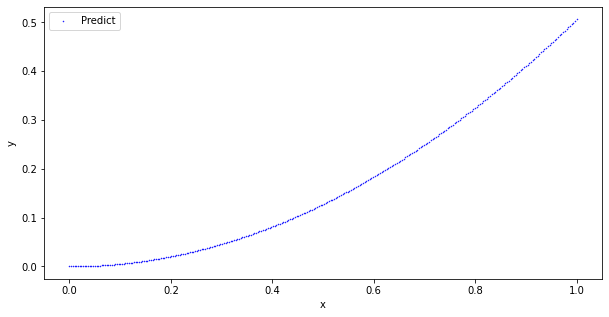

In [14]:
#[TODO]
domain = x.detach().numpy().flatten()
# exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

# plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

# plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

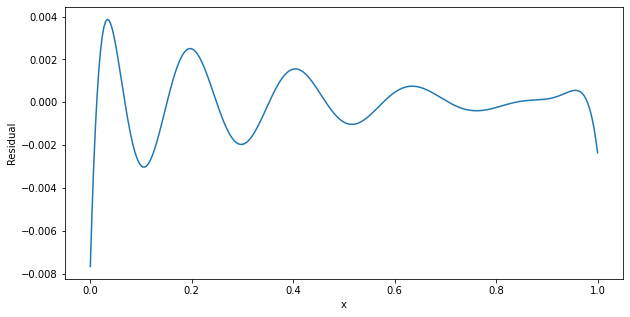

In [15]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

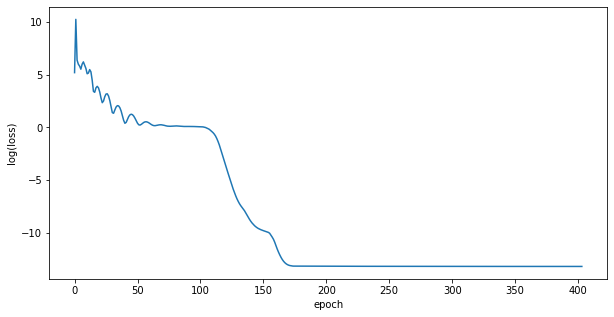

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')